# Cloud-Filtered Custom Mosaics

### Background

A mosaic is a composite image created by combining the most appropriate pixels from a collection of source images. A common use case is to create cloud-free images for applications that are not time-dependent. 

This notebook can be used to create custom Landsat cloud-filtered mosaics for any time period and location. The mosaics can be output as GeoTIFF products for analysis in external GIS tools. The following mosaics are possible:

* Median = midpoint of spectral data
* Geomedian = Australian median product with improved spectral consistency
* Most-Recent = most-recent clear pixel
* Max-NDVI = maximum vegetation response

Users should review the [Cloud Statistics](DCAL_Cloud_Statistics.ipynb) notebook for more information about the cloud statistics for any given temporal and spatial combination. An understanding of the underlying data is important for creating a valid mosaic for further analyses.

## Preliminary steps

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data Cube Configuration
import datacube
dc = datacube.Datacube(app='my_app')

# Import Data Cube API
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()

# Import Data Cube RGB plotting functionality
from utils.data_cube_utilities.dc_rgb import rgb

## Define product and extent

### Available extents

We've listed the available ingested data that you can explore in the ODC Sandbox. The latitude, longitude and time ranges correspond to the boundaries of the ingested data cubes. You'll be able to explore sub-samples of these cubes. You'll also need to provide the platform, product and resolution information for the cube you're subsampling.

#### LS8 Caqueta
Platform: `'LANDSAT_8'` <br>
Product: `'ls8_collection1_AMA_ingest'` <br>
Latitude:   `(0.000134747292617865, 1.077843593651382)` <br>
Longitude:  `(-74.91935994831539, -73.30266193148462)` <br>
Time:       `('2013-04-13', '2018-03-26')` <br>
Resolution: `(-0.000269494585236, 0.000269494585236)`

#### LS8 Vietnam
Platform: `'LANDSAT_8'` <br>
Product: `'ls8_collection1_AMA_ingest'` <br>
Latitude:  `(10.513927001104687, 12.611133863411238)` <br>
Longitude: `(106.79005909290998, 108.91906631627438)` <br>
Time: `('2014-01-14', '2016-12-21')` <br>
Resolution: `(-0.000269494585236, 0.000269494585236)` <br>

#### LS7 Caqueta
Platform: `'LANDSAT_7'` <br>
Product: `'ls7_collection1_AMA_ingest'` <br>
Latitude:  `(0.000134747292617865, 1.077843593651382)` <br>
Longitude: `(-74.91935994831539, -73.30266193148462)` <br>
Time: `('1999-08-21', '2018-03-25')` <br>
Resolution: `(-0.000269494585236, 0.000269494585236)`

#### LS7 Lake Baringo
Platform: `'LANDSAT_7'` <br>
Product: `'ls7_collection1_AMA_ingest'` <br>
Latitude:  `(0.4997747685, 0.7495947795)` <br>
Longitude: `(35.9742163305, 36.473586859499996)` <br>
Time: `('2005-01-08', '2016-12-24')` <br>
Resolution: `(-0.000269493, 0.000269493)`

### Set product information

You can change the values in this cell to specify the product you wish to analyse.

In [3]:
# CHANGE HERE >>>>>>>>>>>>>>>>>

# Select a product and platform
platform = "LANDSAT_7"
product = 'ls7_collection1_AMA_ingest'
resolution = (-0.000269494585236, 0.000269494585236)
output_crs = 'EPSG:4326'

### Set extent information

You can change the values in this cell to specify the extent of the data cube you wish to analyse.

You should select a sub-sample from one of the four data cubes listed above. When subsampling, keep in mind that:
* Your latitude and longitude bounds should be within the extents given.
* Your area should be small to keep load times reasonable (less than 0.5 square degrees).
* Your time period should be within the extents given.

You should format the variables as:
* `latitude = (min_latitude, max_latitude)`
* `longitude = (min_longitude, max_longitude)`
* `time_extents = (min_time, max_time)`, where each time has the format: `'YYYY-MM-DD'`.

In [4]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>

# Select a sub-region to analyse
latitude  = (0.49964002, 0.74964002)
longitude = (36.0, 36.3)
time_extents = ('2016-01-01', '2018-01-01')

### View the region before loading

The next cell will allow you to view the area you'll be analysing by displaying a red bounding box on an interactive map. You can change the extents in the previous cell and rerun the `display_map()` command to see the resulting bounding box.

In [5]:
# Display the map
from utils.data_cube_utilities.dc_display_map import display_map

display_map(latitude,longitude)

## Load the dataset and the required spectral bands and QA parameters

The data is loaded by passing the product and area information to the `dc.load()` function. As a part of this load, we also specify the measurements we want in the form of the Landsat bands. We also include the pixel quality assurance band.

The load can take up to 30 seconds, so please be patient.

In [6]:
# Load the data
landsat_dataset = dc.load(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    measurements=(
        'red',
        'green',
        'blue',
        'nir',
        'swir1',
        'swir2',
        'pixel_qa'
    )
) 

It is often useful to print the loaded data to check the dimensions and data variables

When looking at the dimensions, the numbers for latitude and longitude correspond to the number of pixels in each dimension and the number for time corresponds to the number of time steps. 

In [7]:
# Displays an overview of the loaded data
print(landsat_dataset)

<xarray.Dataset>
Dimensions:    (latitude: 928, longitude: 1114, time: 18)
Coordinates:
  * time       (time) datetime64[ns] 2016-01-07T07:50:28 2016-01-23T07:50:41 ...
  * latitude   (latitude) float64 0.7496 0.7493 0.7491 0.7488 0.7485 0.7483 ...
  * longitude  (longitude) float64 36.0 36.0 36.0 36.0 36.0 36.0 36.0 36.0 ...
Data variables:
    red        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    green      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    blue       (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    nir        (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir1      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    swir2      (time, latitude, longitude) int16 -9999 -9999 -9999 -9999 ...
    pixel_qa   (time, latitude, longitude) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    crs:      EPSG:4326


## Masking out clouds

As part of the utilities for the Open Data Cube, we have defined a function to mask clouds based on the quality assurance information for Landsat. The function returns an 'xarray.DataArray' object containing the mask. This can then be passed to the `where()` function, which masks the data.

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask

cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)

cleaned_dataset = landsat_dataset.where(cloud_mask)

## Generating mosaics

### Median Mosaic

This method masks clouds from imagery using the median of the cloud-free pixels in the time series.

In [9]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
median_composite = create_median_mosaic(cleaned_dataset, cloud_mask)

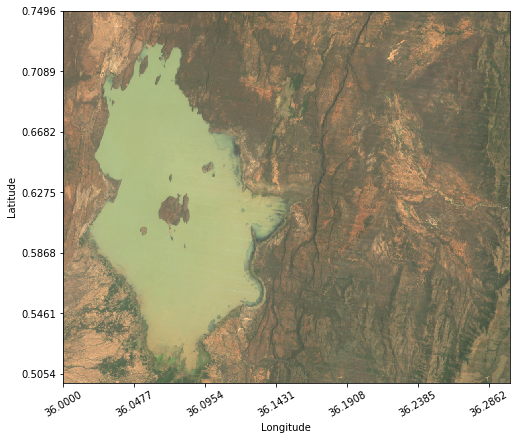

In [10]:
import matplotlib.pyplot as plt

fig_median, ax_median = rgb(median_composite, max_possible=2000)
plt.show()

### GeoMedian Mosaic
This method masks clouds from imagery using the median of the cloud-free pixels in the time series while maintaining the spectral band relationships. This algorithm was developed by Geoscience Australia and produces excellent cloud-filtered mosaic products for further analysis. 

For more information, see the following paper: [High-Dimensional Pixel Composites from Earth Observation Time Series](https://ieeexplore.ieee.org/document/8004469), by Dale Roberts, Norman Mueller, and Alexis McIntyre. IEEE Transactions on Geoscience and Remote Sensing, Vol. 55. No. 11, November 2017.

In [11]:
from utils.data_cube_utilities.dc_mosaic import create_hdmedians_multiple_band_mosaic
geomedian_composite = create_hdmedians_multiple_band_mosaic(cleaned_dataset, cloud_mask)

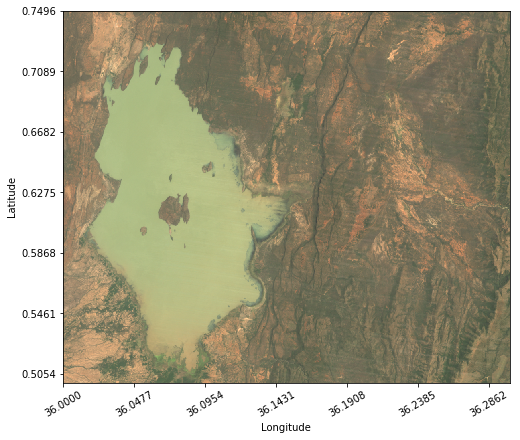

In [12]:
fig_geomed, ax_geomed = rgb(geomedian_composite, max_possible=2000)
plt.show()

### Most Recent Mosaic
This method masks clouds from imagery using the most recent cloud-free pixels in the time series.

In [13]:
from utils.data_cube_utilities.dc_mosaic import create_mosaic
most_recent_composite = create_mosaic(cleaned_dataset, cloud_mask.values)

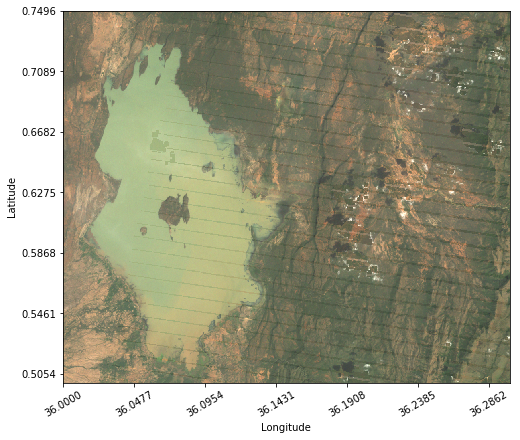

In [14]:
fig_recent, ax_recent = rgb(most_recent_composite, max_possible=2000)
plt.show()

### Max NDVI Mosaic
This method masks clouds from imagery using the Max NDVI across time for cloud-free pixels in the time series. 

In [15]:
from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
max_ndvi_composite = create_max_ndvi_mosaic(cleaned_dataset, cloud_mask.values)

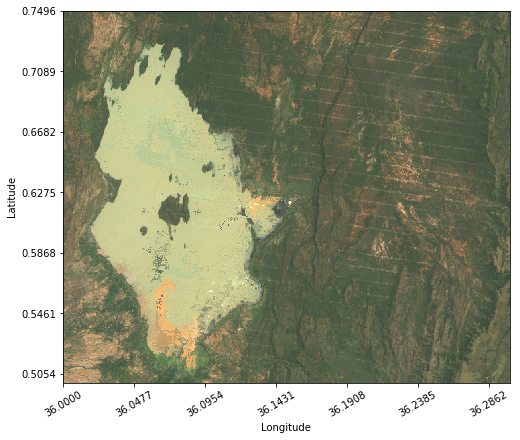

In [16]:
fig_maxndvi, ax_maxndvi = rgb(max_ndvi_composite, max_possible=2000)
plt.show()

## Export to GeoTIFF
To perform further analysis, use the following cells to download the data in GeoTIFF format. This makes use of the data cube utility function `export_slice_to_geotiff()`. 

In [17]:
from utils.data_cube_utilities.import_export import export_slice_to_geotiff

Remove the comment tags (`#`) to export a GeoTIFF output product. There is an export function call for each composite. Change the name of the output file, or it will be overwritten for each run.

In [18]:
# CHANGE HERE >>>>>>>>>>>>>

# export_slice_to_geotiff(median_composite, 'geotiffs/DEMO_median_composite.tif')
# export_slice_to_geotiff(geomedian_composite, 'geotiffs/DEMO_geomedian_composite.tif')
# export_slice_to_geotiff(most_recent_composite, 'geotiffs/DEMO_most_recent_composite.tif')
# export_slice_to_geotiff(max_ndvi_composite, 'geotiffs/DEMO_max_ndvi_composite.tif')

By default, the files have been saved in the `geotiffs` folder, which sits inside the `dcal` folder that this notebook is stored in. Use the following cell to list the contents of the `geotiffs` folder.

*NOTE:* Starting a command with `!` allows you to run that command in the Jupyter environment's command line.

In [19]:
# List all files in the geotiffs folder
!ls geotiffs/

README.md
